In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Synthetic Examples of Partial Dependence Plots

## (1) Gaussian regression function in 2D

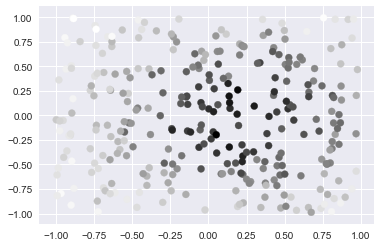

In [24]:
n_features, n_points = 2, 300
std_noise = 0.1
center_of_y = [0.2, 0.]

X = np.random.uniform(low=-1, high=1, size=(n_features * n_points)).reshape(n_points, n_features)
noise = np.random.normal(loc=0, scale=std_noise, size=n_points)
y = np.exp(-np.sum((X-center_of_y)**2, axis=1)) + noise

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y)

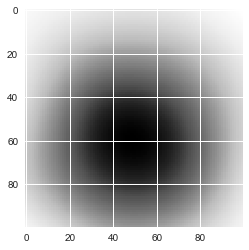

In [29]:
from sklearn.kernel_ridge import KernelRidge

model = KernelRidge(kernel='rbf', gamma=2)
model.fit(X, y)

n_grid1d = 100
x1d = y1d = np.linspace(-1, 1, n_grid1d)
xgrid, ygrid = np.meshgrid(x1d, y1d, indexing='ij')

x_predict = np.array([xgrid.flatten(), ygrid.flatten()]).T

y_predict = model.predict(x_predict).reshape(n_grid1d, n_grid1d)

fig, ax = plt.subplots()
ax.imshow(y_predict)

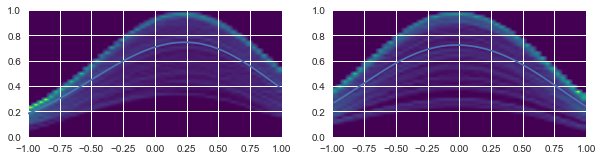

In [63]:
# for the partial dependence plot, we have to loop through the entire dataset

def get_dependence(model, X, i_feature, n_grid1d=50):
    feature_min, feature_max = X[:, i_feature].min(), X[:, i_feature].max()
    feature_range = np.linspace(feature_min, feature_max, n_grid1d)
    
    margins = np.empty((n_points, n_grid1d))
    x_grid = np.empty((n_grid1d, n_features))
    
    for i_point in range(n_points):
        x_grid[:] = X[i_point]
        x_grid[:, i_feature] = feature_range
        margins[i_point] = model.predict(x_grid)
    return feature_range, margins

range1, margins1 = get_dependence(model, X, 0)
mean1 = np.mean(margins1, axis=0)

range2, margins2 = get_dependence(model, X, 1)
mean2 = np.mean(margins2, axis=0)

bins = np.linspace(0, 1, 50)
func = lambda x: np.histogram(x, bins=bins, normed=True)[0]
extent1 = (range1[0], range1[-1], bins[0], bins[-1])
extent2 = (range2[0], range2[-1], bins[0], bins[-1])
hist1 = np.apply_along_axis(arr=margins1, axis=0, func1d=func)
hist2 = np.apply_along_axis(arr=margins2, axis=0, func1d=func)

fig, (col1, col2) = plt.subplots(1, 2, figsize=(10, 5))
col1.imshow(hist1, extent=extent, origin='lower', cmap='viridis', interpolation='bilinear')
col1.plot(range1, mean1)
col2.imshow(hist2, extent=extent, origin='lower', cmap='viridis', interpolation='bilinear')
col2.plot(range2, mean2)

## 3D Example

In [67]:
n_features, n_points = 5, 300
std_noise = 0.1
center_of_y = [0.2, 0., 0.1, 0.5, 0.8]

X = np.random.uniform(low=-1, high=1, size=(n_features * n_points)).reshape(n_points, n_features)
noise = np.random.normal(loc=0, scale=std_noise, size=n_points)
y = np.exp(-np.sum((X-center_of_y)**2, axis=1)) + noise

model = KernelRidge(kernel='rbf', gamma=2)
model.fit(X, y)

KernelRidge(alpha=1, coef0=1, degree=3, gamma=2, kernel='rbf',
      kernel_params=None)

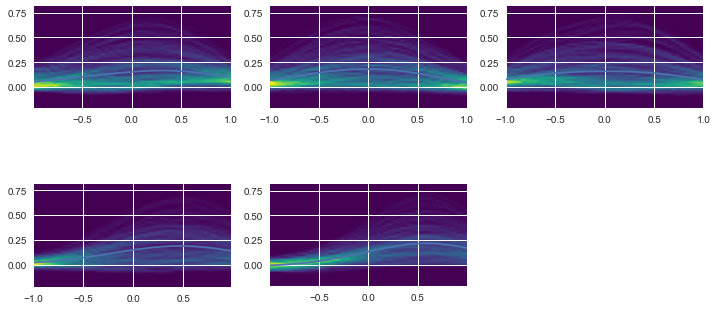

In [76]:
from matplotlib.colors import LogNorm

n_cols = 3
n_rows = np.ceil(n_features/n_cols)
fig = plt.figure(figsize=(n_cols * 4, n_rows * 3))

bins = np.linspace(y.min(), y.max(), 50)
func = lambda x: np.histogram(x, bins=bins, normed=False)[0]

for i_feature in range(n_features):
    ax = fig.add_subplot(n_rows, n_cols, i_feature + 1)
    feature_range, margin = get_dependence(model=model, X=X, i_feature=i_feature)
    mean = np.mean(margin, axis=0)
    extent = (feature_range[0], feature_range[-1], bins[0], bins[-1])
    hist = np.apply_along_axis(arr=margin, axis=0, func1d=func)
    
    ax.imshow(hist, extent=extent, origin='lower', cmap='viridis', interpolation='bilinear')
    ax.plot(feature_range, mean)